In [138]:
#Importamos las librerias
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage import feature
import cv2
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import Sequential

In [2]:
#Importamos el dataset
df = pd.read_csv('data_imagenes.csv')

In [3]:
#Cargamos una imagen
img = cv2.imread('imagenes/an2i_left_angry_sunglasses.pgm', cv2.IMREAD_GRAYSCALE)

In [4]:
#Observamos las dimensiones de la imagen
img.shape

(120, 128)

<center>

# 1. Preprocesamiento de las imagenes
</center>

## 1.1 Aumento de resolución de imagen

In [5]:
#Aumentamos la resolucion de las imagenes con 3 metodos diferentes
high_res_img_linear = cv2.resize(img, (500, 500), interpolation=cv2.INTER_LINEAR)
high_res_img_cubic = cv2.resize(img, (500, 500), interpolation=cv2.INTER_CUBIC)
high_res_img_lanc = cv2.resize(img, (500, 500), interpolation=cv2.INTER_LANCZOS4)

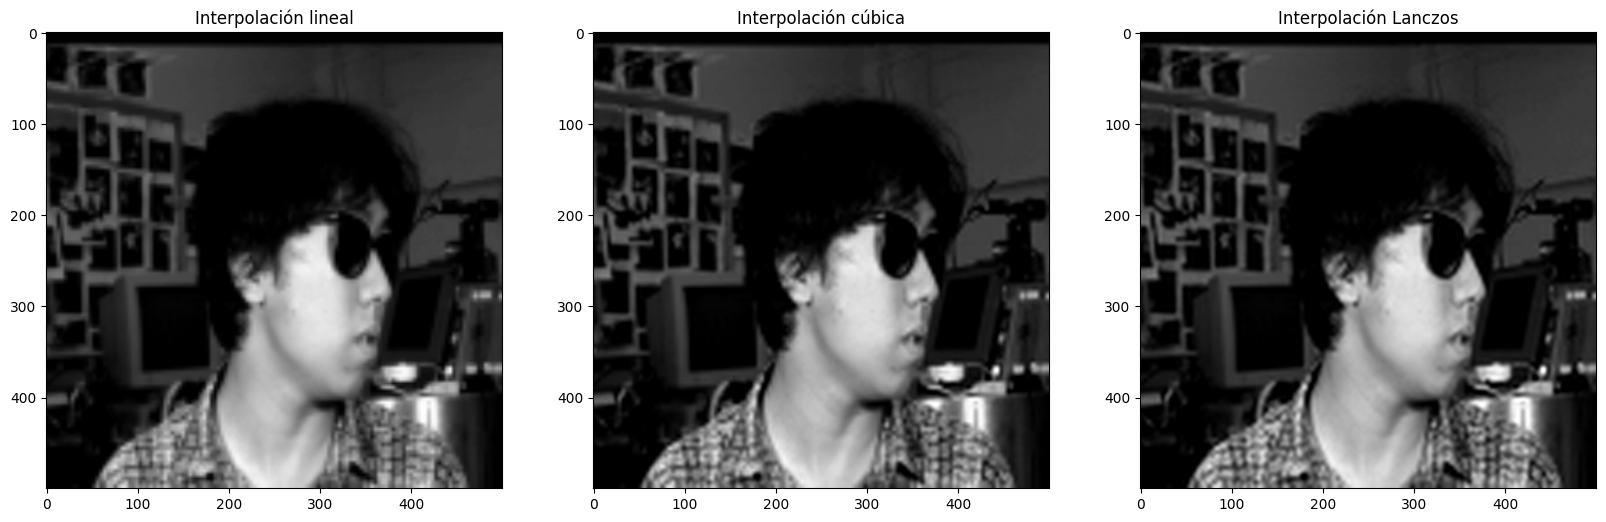

In [6]:
#Se grafican los resultados y elegimos el mejor metodo
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
ax[0].imshow(high_res_img_linear, cmap='gray')
ax[0].set_title('Interpolación lineal')
ax[1].imshow(high_res_img_cubic, cmap='gray')
ax[1].set_title('Interpolación cúbica')
ax[2].imshow(high_res_img_lanc, cmap='gray')
ax[2].set_title('Interpolación Lanczos')
plt.show()


### Al observar los resultados vemos que la interpolacion cubica y de Lanczos no difieren mucho en calidad, mientras que en la interpolacion lineal se ve la menor calidad 

## 1.2 Filtro de alta frecuencia para resaltar detalles finos (bordes)

In [7]:
#Se establece un kernel con valor central mayor que el resto para resaltar los bordes
kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
sharpened_img_linear = cv2.filter2D(high_res_img_linear, -1, kernel)
sharpened_img_cubic = cv2.filter2D(high_res_img_cubic, -1, kernel)
sharpened_img_lanc = cv2.filter2D(high_res_img_lanc, -1, kernel)

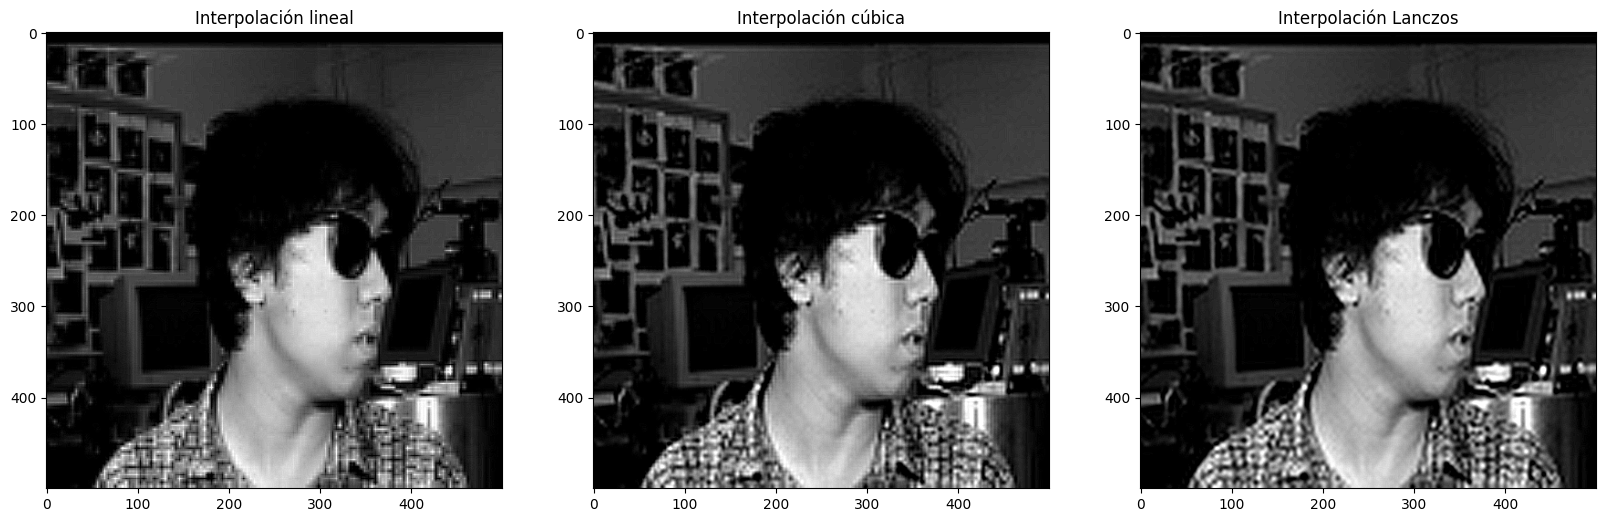

In [8]:
#Se grafican los resultados y elegimos el mejor metodo
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
ax[0].imshow(sharpened_img_linear, cmap='gray')
ax[0].set_title('Interpolación lineal')
ax[1].imshow(sharpened_img_cubic, cmap='gray')
ax[1].set_title('Interpolación cúbica')
ax[2].imshow(sharpened_img_lanc, cmap='gray')
ax[2].set_title('Interpolación Lanczos')
plt.show()

### Elegimos la interpolazion cubica sobre las demas debido a su buen desempeño y bajo coste computacional

## 1.3 Umbralizacion y operacion prixel a pixel

In [68]:
#Se crea una matriz de 50s para sumar y restar a la imagen 
matriz = np.ones(sharpened_img_cubic.shape, dtype=np.uint8)*50
img_brillante = cv2.add(sharpened_img_cubic, matriz)
img_oscura = cv2.subtract(sharpened_img_cubic, matriz)

In [72]:
#Se aplica un treshold binario a las imagenes
img_brillante_treshold = cv2.threshold(img_brillante, 190, 255, cv2.THRESH_BINARY)[1]
img_oscura_treshold = cv2.threshold(img_oscura, 80, 255, cv2.THRESH_BINARY)[1]

In [73]:
#Se aplica un treshold adaptativo a las imagenes
img_brillante_treshold_adaptative = cv2.adaptiveThreshold(img_brillante, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 7, 5)
img_oscura_treshold_adaptative = cv2.adaptiveThreshold(img_oscura, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 7, 5)

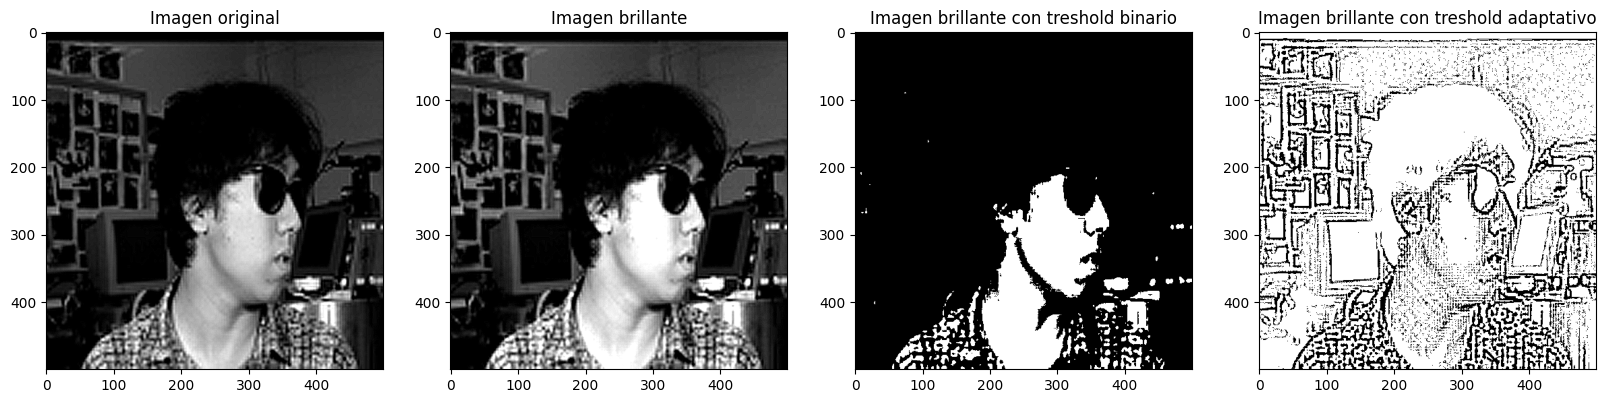

In [74]:
#Se grafican los resultados brillantes
fig, ax = plt.subplots(1, 4, figsize=(20, 6))
plt.title('Imagen brillante')
ax[0].imshow(sharpened_img_cubic, cmap='gray')
ax[0].set_title('Imagen original')
ax[1].imshow(img_brillante, cmap='gray')
ax[1].set_title('Imagen brillante')
ax[2].imshow(img_brillante_treshold, cmap='gray')
ax[2].set_title('Imagen brillante con treshold binario')
ax[3].imshow(img_brillante_treshold_adaptative, cmap='gray')
ax[3].set_title('Imagen brillante con treshold adaptativo')
plt.show()

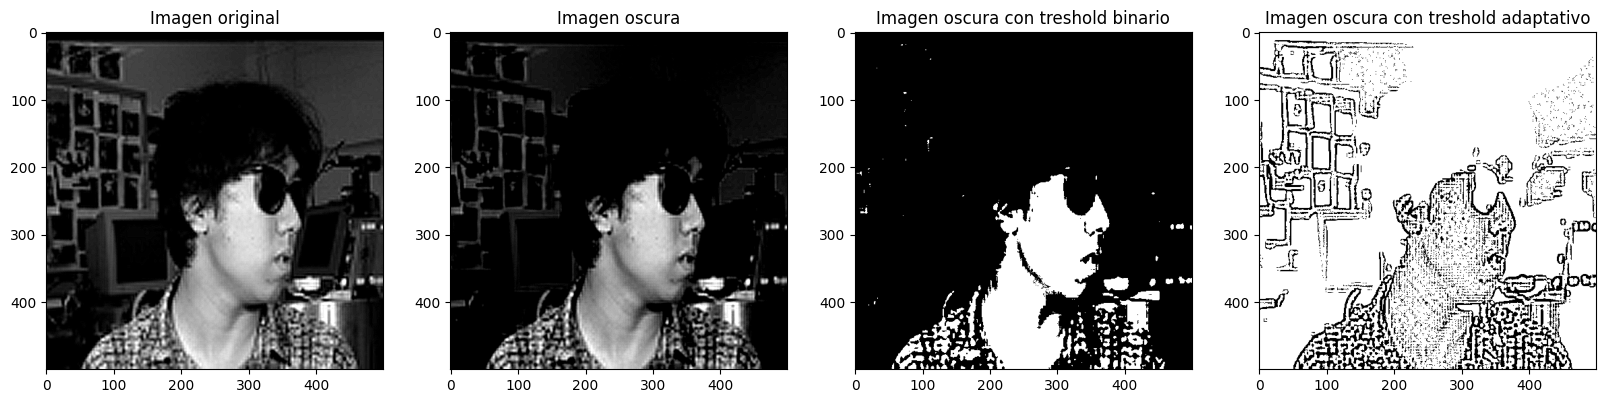

In [75]:
#Se grafican los resultados oscuros
fig, ax = plt.subplots(1, 4, figsize=(20, 6))
plt.title('Imagen oscura')
ax[0].imshow(sharpened_img_cubic, cmap='gray')
ax[0].set_title('Imagen original')
ax[1].imshow(img_oscura, cmap='gray')
ax[1].set_title('Imagen oscura')
ax[2].imshow(img_oscura_treshold, cmap='gray')
ax[2].set_title('Imagen oscura con treshold binario')
ax[3].imshow(img_oscura_treshold_adaptative, cmap='gray')
ax[3].set_title('Imagen oscura con treshold adaptativo')
plt.show()

### Concluimos que la que mejor resalta la caracteristica necesaria es tanto la oscura con treshold binario como la clara con treshold binario, por lo tanto elegimos el metodo claro con treshold binario, exactamente una suma de 50 a la imagen original y un treshold apartir de 160 a 255. Realizamos una funcion donde se aplique lo anterior mencionado a todas las imagenes para observar como se comporta el preprocesamiento   

In [126]:
#Funcion para procesar cada imagen
def procesar_imagen(ruta):
  img = cv2.imread(ruta, cv2.IMREAD_GRAYSCALE)
  high_res_img_cubic = cv2.resize(img, (500, 500), interpolation=cv2.INTER_CUBIC)
  kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
  sharpened_img_cubic = cv2.filter2D(high_res_img_cubic, -1, kernel)
  matriz = np.ones(sharpened_img_cubic.shape, dtype=np.uint8)*50
  img_brillante = cv2.add(sharpened_img_cubic, matriz)
  img_brillante_treshold = cv2.threshold(img_brillante, 160, 255, cv2.THRESH_BINARY)[1]
  return img_brillante_treshold

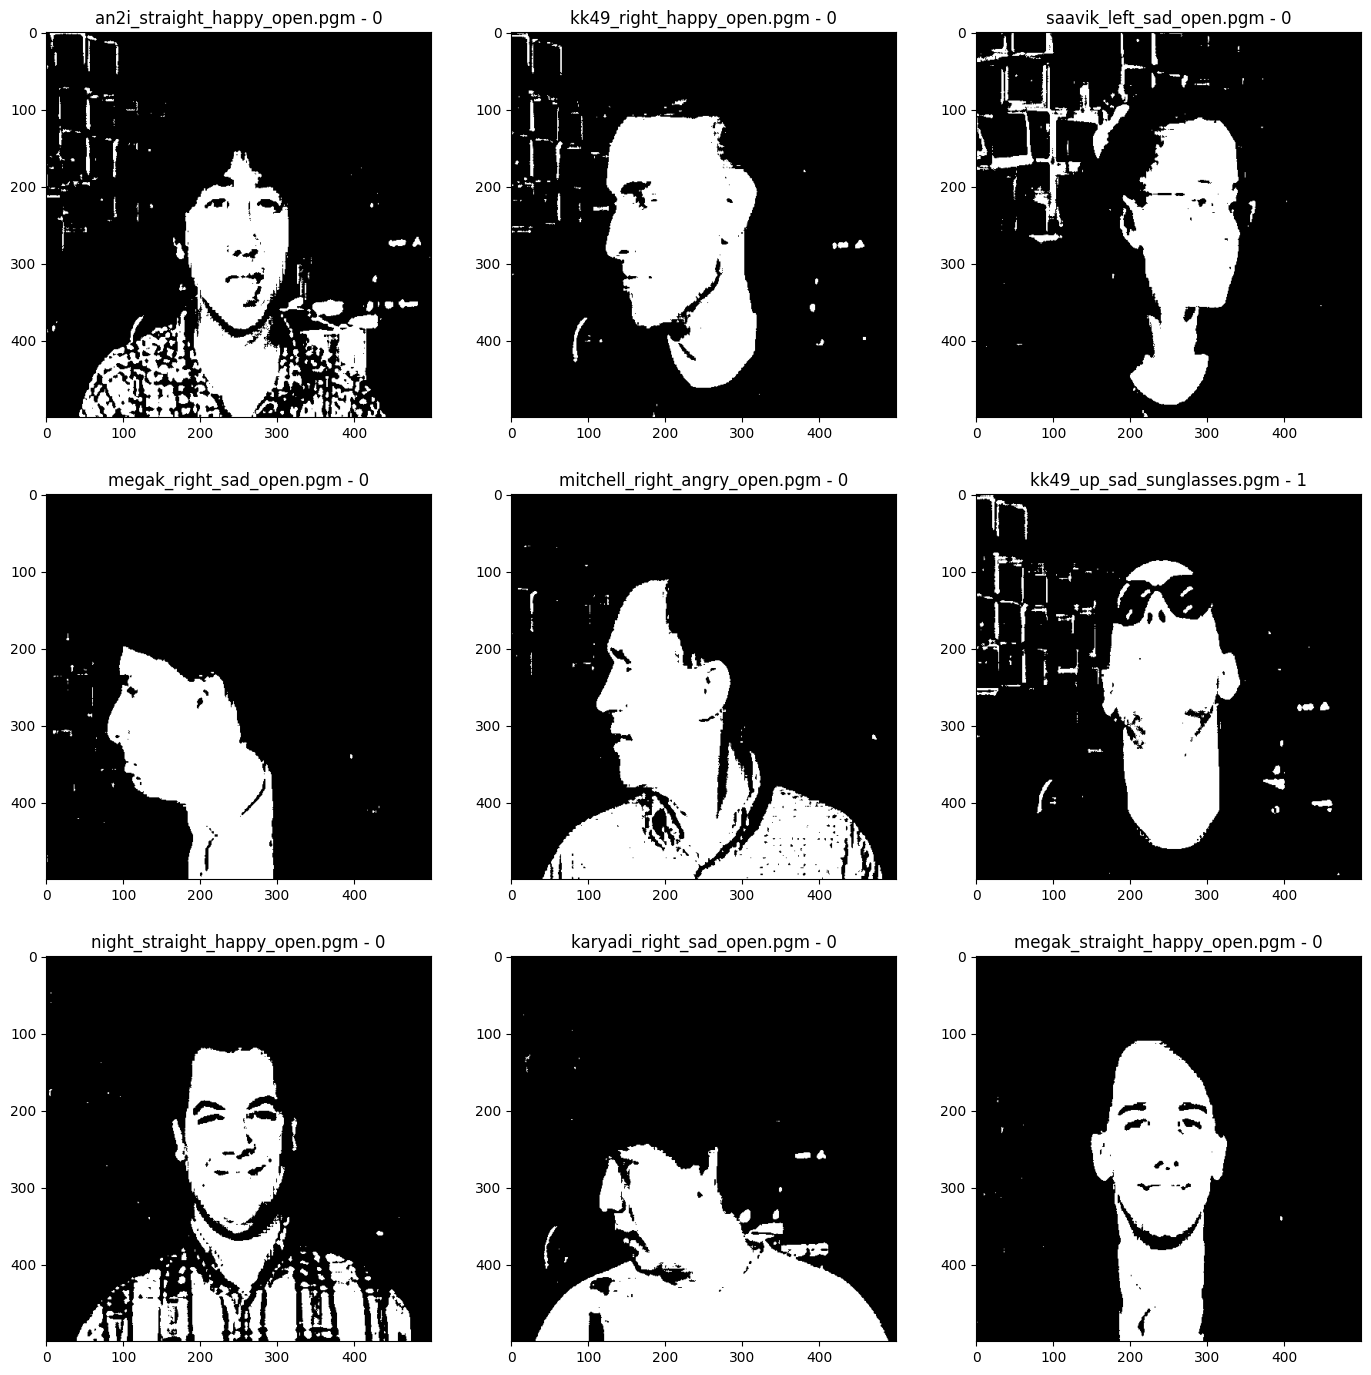

In [127]:
#Aplicar la funcion a una muestra aleatoria de nueve imagenes
fig, ax = plt.subplots(3,3 ,figsize=(17,17))
for i in ax.flatten():
  nombre, etiqueta = df.sample().values[0]
  img = procesar_imagen(f'imagenes/{nombre}')
  i.imshow(img, cmap='gray')
  i.title.set_text(f'{nombre} - {etiqueta}')

### Observamos que en general se aplica bien el procesamiento y se segmenta las gafas de sol cuando estas existen en la imagen

In [131]:
#Creamos un nuevo directorio para guardar las imagenes procesadas
#os.makedirs('imagenes_procesadas', exist_ok=True)

In [132]:
#Extreamos los nombres de las imagenes
#nombres_archivos = os.listdir('imagenes')

In [133]:
#Aplicamos la funcion a todas las imagenes del dataset y guardamos los resultados
"""for i in nombres_archivos:
  img = procesar_imagen(f'imagenes/{i}')
  img = img/255
  cv2.imwrite(f'imagenes_procesadas/{i}', img)"""

<center>

# 2.  Creacion de modelo

</center>